In [36]:
from model import *
from data import *
import os
import matplotlib.pyplot as plt
from utils import plot_segm_history
import numpy as np
from keras.applications.vgg16 import VGG16

## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [19]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data3d/train','frames','masks',data_gen_args,save_to_dir = None)
model = unet()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_50[0][0]                  
____________________________________________________________________________________________

In [20]:
# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_49 (3, 3, 3, 64)
conv2d_50 (3, 3, 64, 64)
conv2d_51 (3, 3, 64, 128)
conv2d_52 (3, 3, 128, 128)
conv2d_53 (3, 3, 128, 256)
conv2d_54 (3, 3, 256, 256)
conv2d_55 (3, 3, 256, 512)
conv2d_56 (3, 3, 512, 512)
conv2d_57 (3, 3, 512, 1024)
conv2d_58 (3, 3, 1024, 1024)
conv2d_59 (2, 2, 1024, 512)
conv2d_60 (3, 3, 1024, 512)
conv2d_61 (3, 3, 512, 512)
conv2d_62 (2, 2, 512, 256)
conv2d_63 (3, 3, 512, 256)
conv2d_64 (3, 3, 256, 256)
conv2d_65 (2, 2, 256, 128)
conv2d_66 (3, 3, 256, 128)
conv2d_67 (3, 3, 128, 128)
conv2d_68 (2, 2, 128, 64)
conv2d_69 (3, 3, 128, 64)
conv2d_70 (3, 3, 64, 64)
conv2d_71 (3, 3, 64, 2)
conv2d_72 (1, 1, 2, 1)


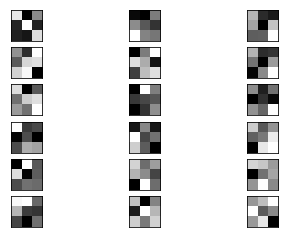

In [21]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [22]:
#now feature maps
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 conv2d_49 (None, 256, 256, 64)
2 conv2d_50 (None, 256, 256, 64)
4 conv2d_51 (None, 128, 128, 128)
5 conv2d_52 (None, 128, 128, 128)
7 conv2d_53 (None, 64, 64, 256)
8 conv2d_54 (None, 64, 64, 256)
10 conv2d_55 (None, 32, 32, 512)
11 conv2d_56 (None, 32, 32, 512)
14 conv2d_57 (None, 16, 16, 1024)
15 conv2d_58 (None, 16, 16, 1024)
18 conv2d_59 (None, 32, 32, 512)
20 conv2d_60 (None, 32, 32, 512)
21 conv2d_61 (None, 32, 32, 512)
23 conv2d_62 (None, 64, 64, 256)
25 conv2d_63 (None, 64, 64, 256)
26 conv2d_64 (None, 64, 64, 256)
28 conv2d_65 (None, 128, 128, 128)
30 conv2d_66 (None, 128, 128, 128)
31 conv2d_67 (None, 128, 128, 128)
33 conv2d_68 (None, 256, 256, 64)
35 conv2d_69 (None, 256, 256, 64)
36 conv2d_70 (None, 256, 256, 64)
37 conv2d_71 (None, 256, 256, 2)
38 conv2d_72 (None, 256, 256, 1)


In [44]:
# redefine model to output right after the first hidden layer
model2 = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [47]:
# load the image with the required shape
img = tf.keras.preprocessing.image.load_img('bird.jpg', target_size=(256, 256))
# convert the image to an array
img = tf.keras.preprocessing.image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = tf.keras.applications.vgg16.preprocess_input(img)

In [48]:
feature_maps = model2.predict(img)

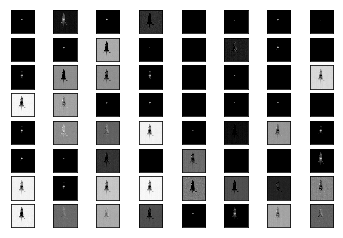

In [50]:
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

IndexError: too many indices for array

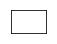

In [51]:
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	plt.show()

In [26]:
model_checkpoint = ModelCheckpoint('unet3d.hdf5', monitor='loss',verbose=1, save_best_only=False)
history = model2.fit_generator(myGene,steps_per_epoch=50,epochs=1,callbacks=[model_checkpoint])

RuntimeError: You must compile your model before using it.

### Train with npy file

In [3]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


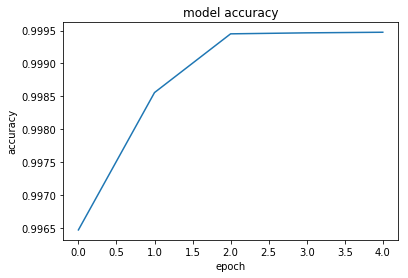

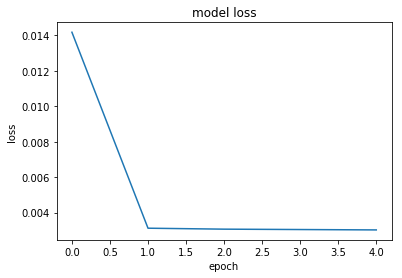

[0.99647135, 0.99855816, 0.9994505, 0.9994655, 0.9994747]


In [4]:
plot_segm_history(history)
print(history.history['accuracy'])


In [ ]:
#imgs_train,imgs_mask_train = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

### test your model and save predicted results

In [5]:
testGene = testGenerator("data3d/test")
model = unet()
model.load_weights("unet3d.hdf5")
results = model.predict_generator(testGene,10,verbose=1)

if not os.path.exists("data3d/results"):
    os.makedirs("data3d/results")
    
saveResult("data3d/results",results)

10/10 [==============================] - 6s 587ms/step


/home/asli/anaconda3/envs/unet/lib/python3.5/site-packages/skimage/io/_io.py:141: UserWarning: data3d/results/0_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/asli/anaconda3/envs/unet/lib/python3.5/site-packages/skimage/io/_io.py:141: UserWarning: data3d/results/1_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/asli/anaconda3/envs/unet/lib/python3.5/site-packages/skimage/io/_io.py:141: UserWarning: data3d/results/2_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/asli/anaconda3/envs/unet/lib/python3.5/site-packages/skima

In [ ]:
set(results[0].ravel())

In [ ]:
import matplotlib.pyplot as plt
import collections

In [ ]:
plt.imshow(results[0][:,:,0])

In [ ]:
results[0].shape

In [ ]:
for image in results:
    print(collections.Counter(image.ravel()))